В данном ноутбуке производится загрузка данных о транзакциях, EDA, выявление аномалий с помощью различных методов (статистических, supervised и unsupervised), сравнение качества выявления аномалий с помощью различных метрик классификации и визуализация полученных аномалий.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import zipfile

warnings.filterwarnings("ignore")

### 1. Загрузка данных

In [2]:
data_filename = 'creditcard.csv'
archive_filename = 'creditcard.zip'
if not os.path.exists(data_filename):
    with zipfile.ZipFile(archive_filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [3]:
data = pd.read_csv(data_filename, sep=',')

Набор данных содержит данные о транзакциях, совершённых по кредитным картам европейскими держателями карт в сентябре 2013 года.
В этом наборе представлены транзакции, совершённые за два дня. Из 284 807 транзакций зафиксировано 492 случая мошенничества. Набор данных крайне несбалансирован: мошенничество составляет 0,172% от всех транзакций.

Он содержит только числовые входные переменные, полученные в результате PCA-преобразования. Признаки V1, V2, … V28 — это главные компоненты, полученные с помощью PCA. Единственные признаки, не преобразованные с помощью PCA, — это «Time» и «Amount». Признак «Time» содержит количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных. Признак «Amount» — это сумма транзакции, которую можно использовать для обучения, зависящего от примера и чувствительного к стоимости. Признак «Class» — это n таргет, кот. принимает значение 1 в случае мошенничества и 0 в противном случае.

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Датасет содержит:
 - 28 параметров, полученных в результате PCA (V1...V28).
 - Time (время между транзакциями в секундах),
 - Amount (сумма транзакции)
 - Class ([0, 1], обозначающий была ли транзакция мошеннической)

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Общее количество записей - 284807.
Минимальные и максимальные значения представлены в строках min и max.
Среднее и стандартное отклонение представлены в строках mean и std.
1, 2 и 3 квартили представлены в строках 25%, 50% и 75%.
Значения V-признаков колеблются примерно между -113 и 120.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Столбец Class содержит целочисленные значения 0 и 1. Остальные колонки содержат float64.

In [7]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Пропусков данные в датасете нет


### 2. EDA

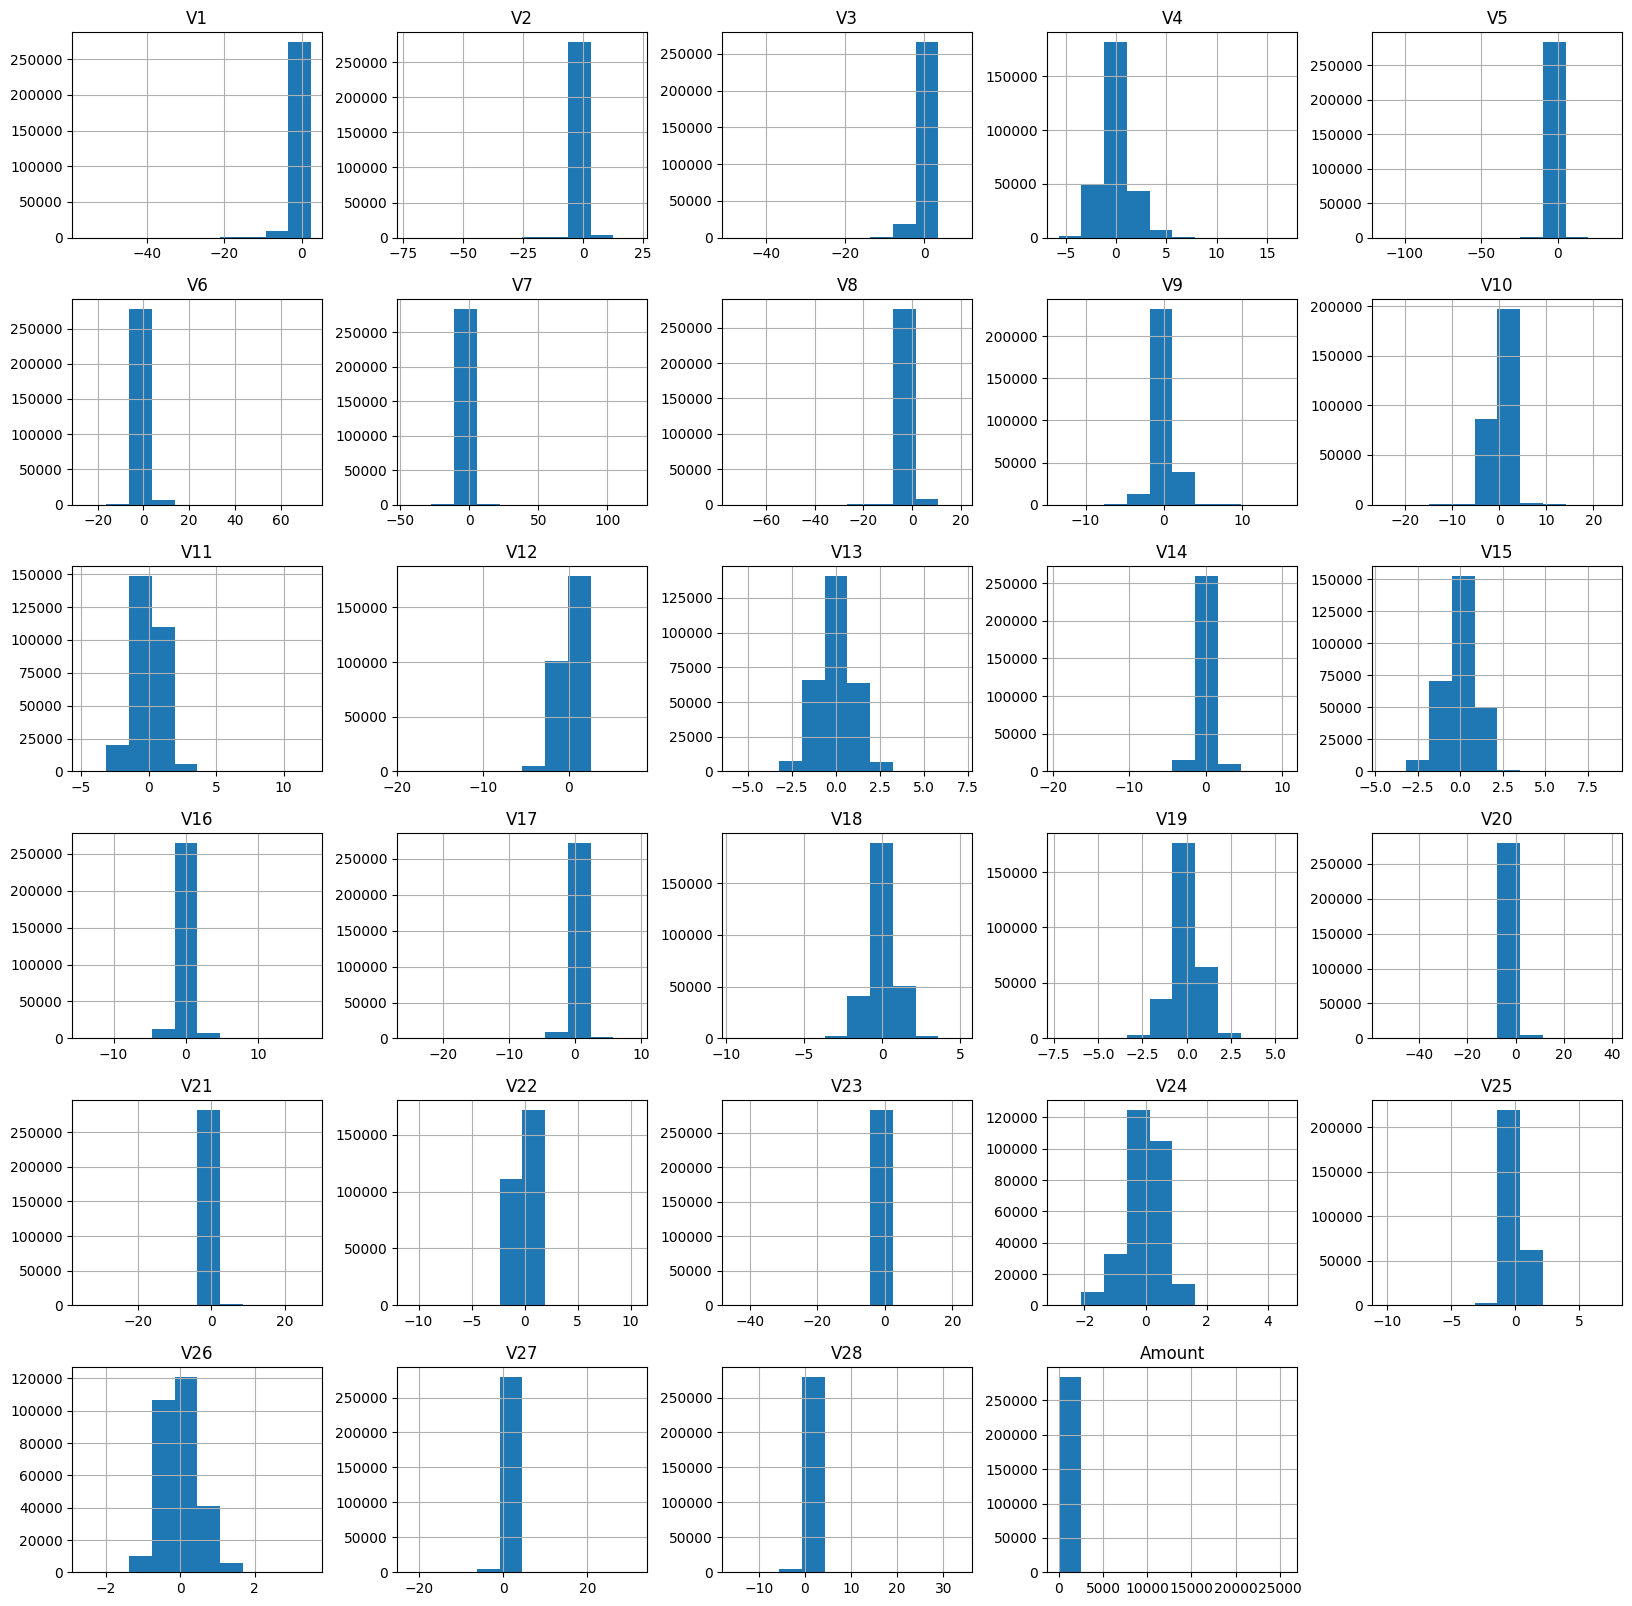

In [8]:
data.drop(['Time', 'Class'], axis=1).hist(figsize=(20, 20));

Визуально в датасете нет признаков, имеющих нормальное распределение.

Проверим на нормальность с помощью стат. тестов: Shapiro-Wilk, D'Agostino, Jarque-Bera

In [9]:
from scipy.stats import shapiro, normaltest, jarque_bera


def check_normality(data, alpha=0.05):
    """Проверяет распределение на нормальность с помощью нескольких тестов"""
    tests = {
        'Shapiro-Wilk': shapiro,
        'D\'Agostino': normaltest,
        'Jarque-Bera': jarque_bera
    }

    results = {}
    for name, test_func in tests.items():
        stat, p_value = test_func(data)
        results[name] = {'Statistic': stat, 'p-value': p_value, 'Normal': p_value > alpha}

    return pd.DataFrame(results)


for column in data.drop(['Time', 'Class'], axis=1).columns:
    print(f"Проверка на нормальность для {column}:")
    print(check_normality(data[column]))

Проверка на нормальность для V1:
          Shapiro-Wilk     D'Agostino      Jarque-Bera
Statistic     0.798984  222086.395442  13034626.424434
p-value            0.0            0.0              0.0
Normal           False          False            False
Проверка на нормальность для V2:
          Shapiro-Wilk     D'Agostino       Jarque-Bera
Statistic     0.739692  297509.669059  109860958.045404
p-value            0.0            0.0               0.0
Normal           False          False             False
Проверка на нормальность для V3:
          Shapiro-Wilk     D'Agostino     Jarque-Bera
Statistic     0.907635  172313.138289  8646829.024218
p-value            0.0            0.0             0.0
Normal           False          False           False
Проверка на нормальность для V4:
          Shapiro-Wilk    D'Agostino    Jarque-Bera
Statistic     0.969207  35667.452068  104129.384215
p-value            0.0           0.0            0.0
Normal           False         False          False


Согласно стат. тестам, в датасете нет признаков, имеющих нормальное распределение.

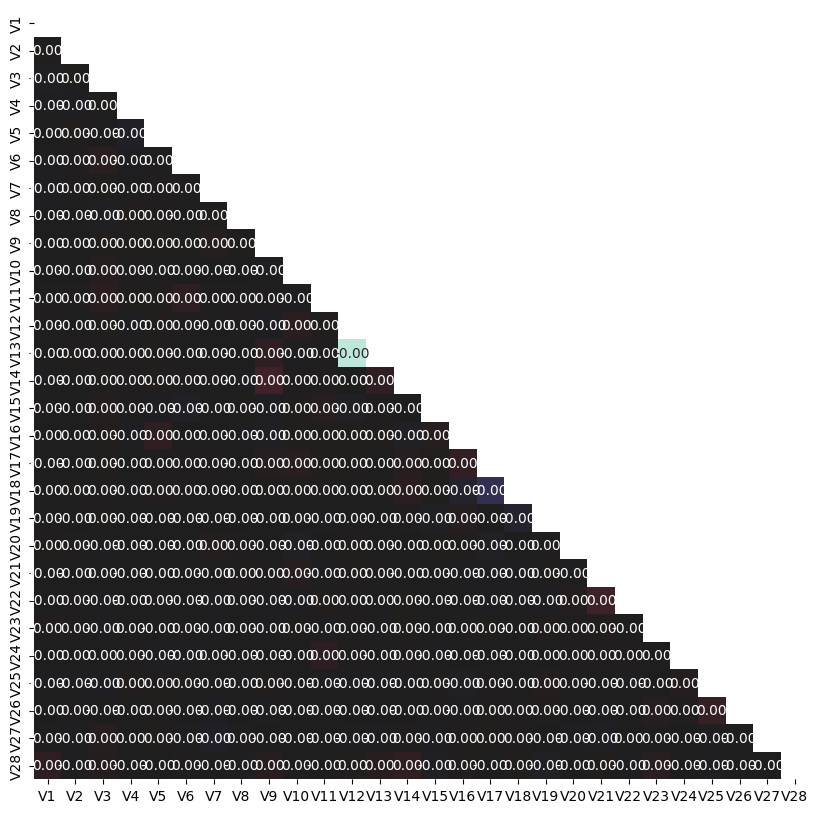

In [10]:
plt.figure(figsize=(10, 10))

corr_matrix = data.drop(['Time', 'Class', 'Amount'], axis=1).corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

На карте корреляций видно, что V-признаки плохо скорелированны между собой.

In [11]:
def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
        sum(outliers), 100 * sum(outliers) / len(outliers)))

In [12]:
anomalies_report(data['Class'])

Total number of outliers: 492
Percentage of outliers:   0.17%


Количество аномалий, размеченных в переменной Class, равно 492

### 3. Аномалии

Определение выбросов с помощью метода "3 сигмы"

In [13]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(axis=1)
    return anomalies, up_bound, low_bound

In [14]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns

    outliers = pd.Series(data=[False] * len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100 * sum(anomalies) / len(anomalies)]
        outliers[anomalies[anomalies].index] = True

    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns = ['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)

    return comparison_table, outliers

In [15]:
data_features = data.drop(['Time', 'Class', 'Amount'], axis=1)
data_features

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533


In [16]:
comparison_table, std_outliers = get_column_outliers(data_features, threshold=4)
anomalies_report(std_outliers)

Total number of outliers: 13605
Percentage of outliers:   4.78%


За пределами 4х сигм находится 13605 (4.78%) выбросов.

In [17]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
V27,1.614530,-1.614530,2844.0,0.998571
V8,4.777412,-4.777412,2839.0,0.996815
V20,3.083700,-3.083700,2609.0,0.916059
V21,2.938096,-2.938096,2395.0,0.840920
V10,4.355399,-4.355399,2194.0,0.770346
V2,6.605234,-6.605234,2182.0,0.766133
V23,2.497841,-2.497841,2064.0,0.724701
V7,4.948374,-4.948374,1902.0,0.667821
V1,7.834783,-7.834783,1871.0,0.656936
V28,1.320333,-1.320333,1826.0,0.641136


Больше всего выбросов находится в признаке V27 (2844 или 0.99%), меньше всего в признаке V13 (11 или 0.003%)

Сравним выявленные аномалии с размеченными, с помощью метрик для классификации

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def quality_report(data, prediction, model_name):
    quality_data = pd.DataFrame(
        columns=['All', 'Actl', 'Pred', 'Accr', 'Prec',
                 'Recl', 'F1', 'TP', 'FP', 'TN', 'FN'],
        index=[model_name])

    quality_data['All'] = len(data)
    quality_data['Actl'] = len(data[data['Class'] == 1]['Class'])
    quality_data['Pred'] = (prediction == 1).sum()
    quality_data['Accr'] = round(accuracy_score(data['Class'], prediction), 3)
    quality_data['Prec'] = round(precision_score(data['Class'], prediction), 3)
    quality_data['Recl'] = round(recall_score(data['Class'], prediction), 3)
    quality_data['F1'] = round(f1_score(data['Class'], prediction), 3)

    tn, fp, fn, tp = confusion_matrix(data['Class'], prediction).ravel()
    quality_data['TP'] = tp
    quality_data['FP'] = fp
    quality_data['TN'] = tn
    quality_data['FN'] = fn

    return quality_data


In [19]:
std_report = quality_report(data, std_outliers, 'std')
std_report

,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
std,284807,492,13605,0.953,0.031,0.866,0.06,426,13179,271136,66


Поскольку датасет не сбалансирован Accuracy показывает 95%, Precision 3% (много ложноположительных результатов), Recall 86% (мало ложноотрицательных результатов). True Positive = 426, тем не менее, говорит о том, что метод 4х сигм захватил большее количество фактических выбросов. Однако False Positive = 13179 говорит о том, что количество ложноположительных результатов кратно больше.

In [20]:
comparison_table, std_outliers = get_column_outliers(data_features, threshold=17.6)
anomalies_report(std_outliers)
std_report = quality_report(data, std_outliers, 'std')
std_report

Total number of outliers: 498
Percentage of outliers:   0.17%


,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
std,284807,492,498,0.997,0.183,0.185,0.184,91,407,283908,401


Подобрав threshold таким образом, чтобы количество предсказанных аномалий, сравнялось с фактическим количеством, получаем  качество примерно 18%.

Определение выбросов с помощью IQR

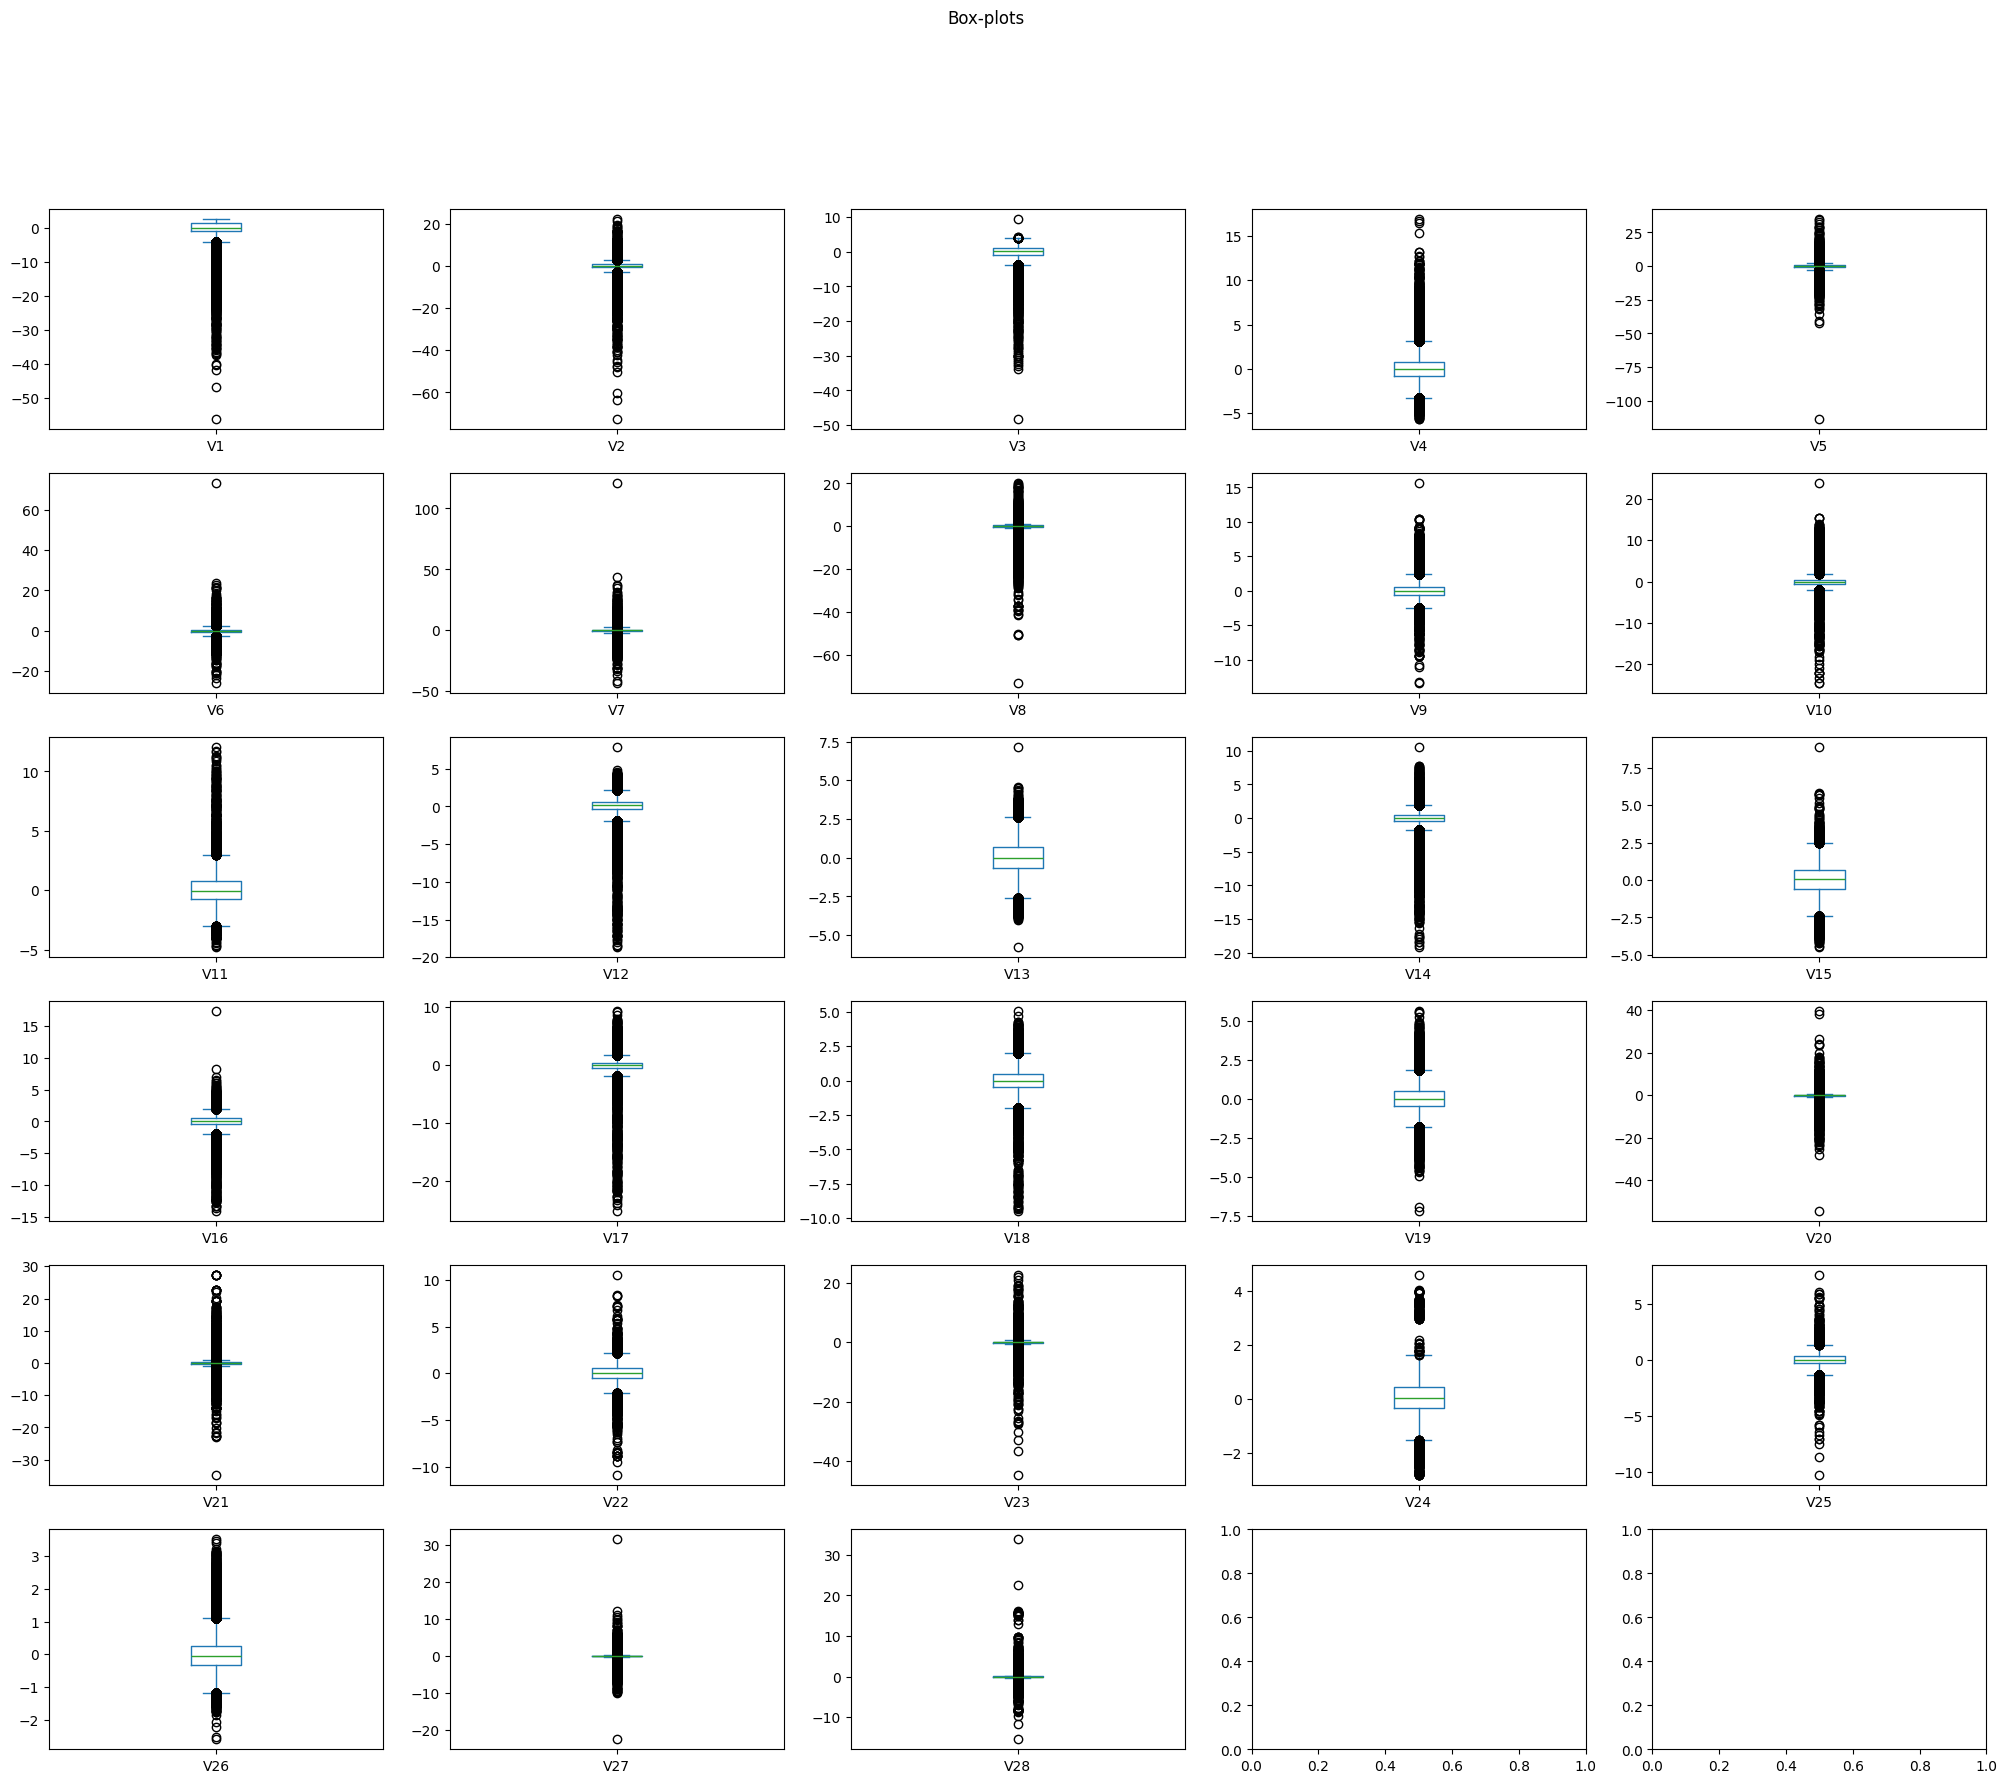

In [21]:
fig, axes = plt.subplots(6, 5, figsize=(25, 20))
fig.suptitle('Box-plots')

row = 0
col = 0

for ax, feature in enumerate(data_features):
    data_features[feature].plot.box(ax=axes[row, col])
    col += 1
    if col > 4:
        row += 1
        col = 0

На боксплотах видно, что все признаки имеют много аномалий за пределами межквартильного размаха.

In [22]:
def outlier_iqr(data, col, threshold=1.5):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(axis=1)
    return anomalies, up_bound, low_bound

In [23]:
comparison_table, iqr_outliers = get_column_outliers(data_features, function=outlier_iqr, threshold=3)
anomalies_report(iqr_outliers)

Total number of outliers: 43349
Percentage of outliers:   15.22%


Количество аномалий, определенных методом межквартильного размаха (threshold=3) составило 43349 (15.22%)

In [24]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
V27,0.576699,-0.556493,16524.0,5.801824
V20,1.167327,-1.246008,13385.0,4.699674
V28,0.471999,-0.446679,12573.0,4.414568
V8,1.935273,-1.816557,11285.0,3.962332
V23,1.076107,-1.090312,8135.0,2.856320
V21,1.430694,-1.472711,6934.0,2.434631
V6,3.899146,-4.268877,5389.0,1.892159
V2,5.010545,-4.805371,4453.0,1.563515
V10,3.421971,-3.503473,3208.0,1.126377
V7,3.943972,-3.927612,3051.0,1.071252


Больше всего выбросов находится в признаке V27 (16524 или 5.8%), меньше всего в признаке V13 (2 или 0.0007%)


Сравним выявленные аномалии с размеченными, с помощью метрик для классификации

In [25]:
comparison_table, iqr_outliers = get_column_outliers(data_features, function=outlier_iqr, threshold=35)
anomalies_report(iqr_outliers)
iqr_report = quality_report(data, iqr_outliers, 'IQR')
iqr_report

Total number of outliers: 496
Percentage of outliers:   0.17%


,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
IQR,284807,492,496,0.997,0.038,0.039,0.038,19,477,283838,473


Подобрав threshold таким образом, чтобы количество предсказанных аномалий, сравнялось с фактическим количеством, получаем качество примерно 3%.

Кластеризация

In [26]:
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler


class DistanceOutliers(BaseEstimator):
    """
    -----------
    Parameters:

    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)

    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """

    def __init__(self, metric='euclidean', percentile=99.83):
        self.metric = metric
        self.percentile = percentile

    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)

    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

Так как мы имеем дело с расстояниями - нужно убедиться, что все данные в одном масштабе

In [27]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features),
    columns=data_features.columns
)

In [28]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=99.83)
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)
anomalies_report(euclidian_outliers)

Total number of outliers: 485
Percentage of outliers:   0.17%


In [29]:
euclidian_report = quality_report(data, pd.Series(euclidian_outliers), 'euclidian')
euclidian_report

,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
euclidian,284807,492,485,0.997,0.072,0.071,0.072,35,450,283865,457


Точность определения аномалий с помощью "Euclidean Distance Outliers" примерна равна 7%.

In [30]:
citiblock_model = DistanceOutliers(metric='cityblock', percentile=99.83)
citiblock_model.fit(scaled_data)
cityblock_outliers = citiblock_model.predict(scaled_data)
anomalies_report(cityblock_outliers)

labeled_data = data_features.copy()
labeled_data['is_outlier'] = cityblock_outliers

Total number of outliers: 485
Percentage of outliers:   0.17%


In [31]:
cityblock_report = quality_report(data, pd.Series(cityblock_outliers), 'cityblock')
cityblock_report

,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
cityblock,284807,492,485,0.997,0.233,0.23,0.231,113,372,283943,379


Точность определения аномалий с помощью "Cityblock Distance Outliers" примерна равна 23%.

DBSCAN (Density-based)

In [32]:
from sklearn.cluster import DBSCAN

# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
# eps = 0.01
# eps_history = [eps]
#
# cnt = 0
# while outlier_percentage > 0.05:
#     %time model = DBSCAN(eps=eps).fit(scaled_data)
#     %time labels = model.labels_
#     num_clusters.append(len(np.unique(labels)) - 1)
#     labels = np.array([1 if label == -1 else 0 for label in labels])
#     # считаем текущий процент "шума"
#     outlier_percentage = sum(labels == 1) / len(labels)
#     eps += 0.05
#     eps_history.append(eps)
#     anomaly_percentage.append(outlier_percentage)
#     cnt += 1
#     print(f'{cnt}) outlier_percentage: {outlier_percentage}, eps: {eps}')

eps = 3
model = DBSCAN(eps)
model.fit(scaled_data)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

In [33]:
eps

3

In [34]:
anomalies_report(density_outlier)

Total number of outliers: 23660
Percentage of outliers:   8.31%


In [35]:
density_report = quality_report(data, pd.Series(density_outlier), 'density')
density_report

,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
density,284807,492,23660,0.918,0.016,0.748,0.03,368,23292,261023,124


Точность определения аномалий с помощью DBSCAN примерна равна 3%.

Примечание: эксперимент по подбору eps для DBSCAN пришлось прервать при eps=3, т.к. обучение модели требовало большей оперативной памяти. Метод снижения размерности или другую реализацию DBSCAN в данном случае было решено не мспользовать.

One-Class SVM

In [36]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.0017, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [37]:
anomalies_report(svm_outliers)

Total number of outliers: 2701
Percentage of outliers:   0.95%


In [38]:
svm_report = quality_report(data, pd.Series(svm_outliers), 'svm')
svm_report

,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
svm,284807,492,2701,0.99,0.057,0.311,0.096,153,2548,281767,339


Точность определения аномалий с помощью OneClassSVM примерна равна 9%.

Isolation Forest

In [39]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=0.0017,
                                   max_features=1.0, bootstrap=True)
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [40]:
anomalies_report(isolation_outliers)

Total number of outliers: 485
Percentage of outliers:   0.17%


In [41]:
isolation_report = quality_report(data, pd.Series(isolation_outliers), 'isolation')
isolation_report

,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
isolation,284807,492,485,0.998,0.295,0.291,0.293,143,342,283973,349


Точность определения аномалий с помощью IsolationForest примерна равна 30%.

### 4. Финальное сравнение

In [42]:
summary = np.concatenate((
    [std_outliers],
    [iqr_outliers],
    [euclidian_outliers],
    [cityblock_outliers],
    [density_outlier],
    [svm_outliers],
    [isolation_outliers]
))

In [43]:
summary = pd.DataFrame(
    summary.T,
    columns=['std', 'iqr', 'euclid', 'cityblock', 'dbscan', 'svm', 'isolation']
)
summary

,std,iqr,euclid,cityblock,dbscan,svm,isolation
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
284802,0,0,0,0,0,0,0
284803,0,0,0,0,0,0,0
284804,0,0,0,0,0,0,0
284805,0,0,0,0,0,0,0


In [44]:
models_report = pd.concat(
    [std_report, iqr_report, euclidian_report, cityblock_report, density_report, svm_report, isolation_report])
models_report

,All,Actl,Pred,Accr,Prec,Recl,F1,TP,FP,TN,FN
std,284807,492,498,0.997,0.183,0.185,0.184,91,407,283908,401
IQR,284807,492,496,0.997,0.038,0.039,0.038,19,477,283838,473
euclidian,284807,492,485,0.997,0.072,0.071,0.072,35,450,283865,457
cityblock,284807,492,485,0.997,0.233,0.230,0.231,113,372,283943,379
density,284807,492,23660,0.918,0.016,0.748,0.030,368,23292,261023,124
svm,284807,492,2701,0.990,0.057,0.311,0.096,153,2548,281767,339
isolation,284807,492,485,0.998,0.295,0.291,0.293,143,342,283973,349


Судя по метрикам, ближе всего к реальным аномалиям удалось приблязиться с помощью cityblock (23%) и isolation forest (30%).

### 5. Снижение размерности и визуализация

Снижение размерности

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=50, n_jobs=-1)
tsne_transformed = tsne.fit_transform(scaled_data)

Реальные аномалии

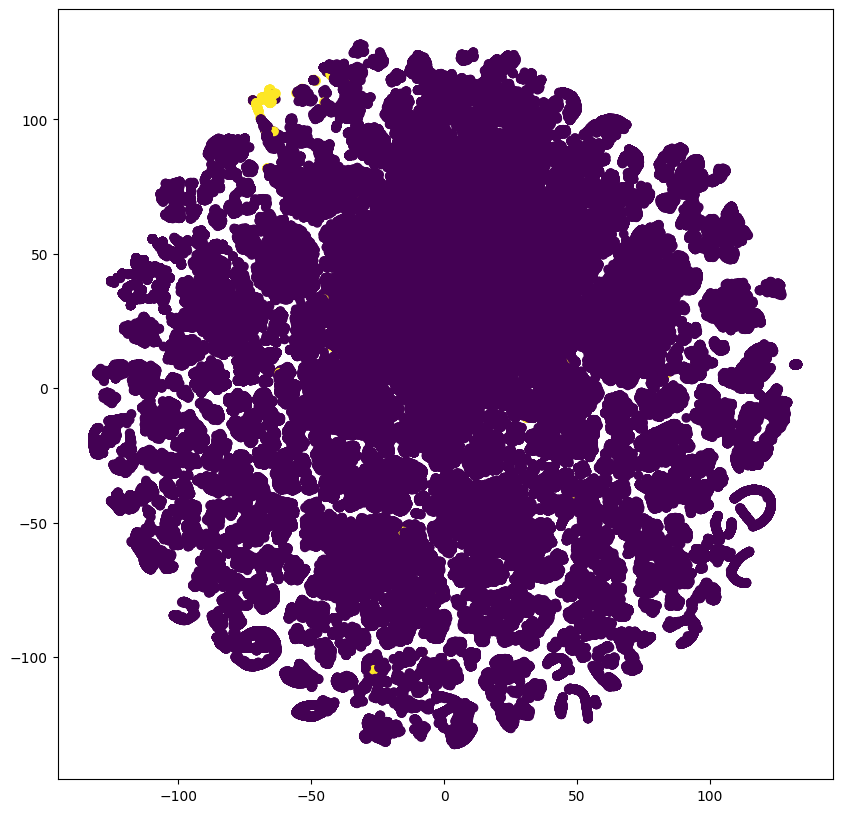

In [46]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=data['Class'].to_numpy());

3 сигмы

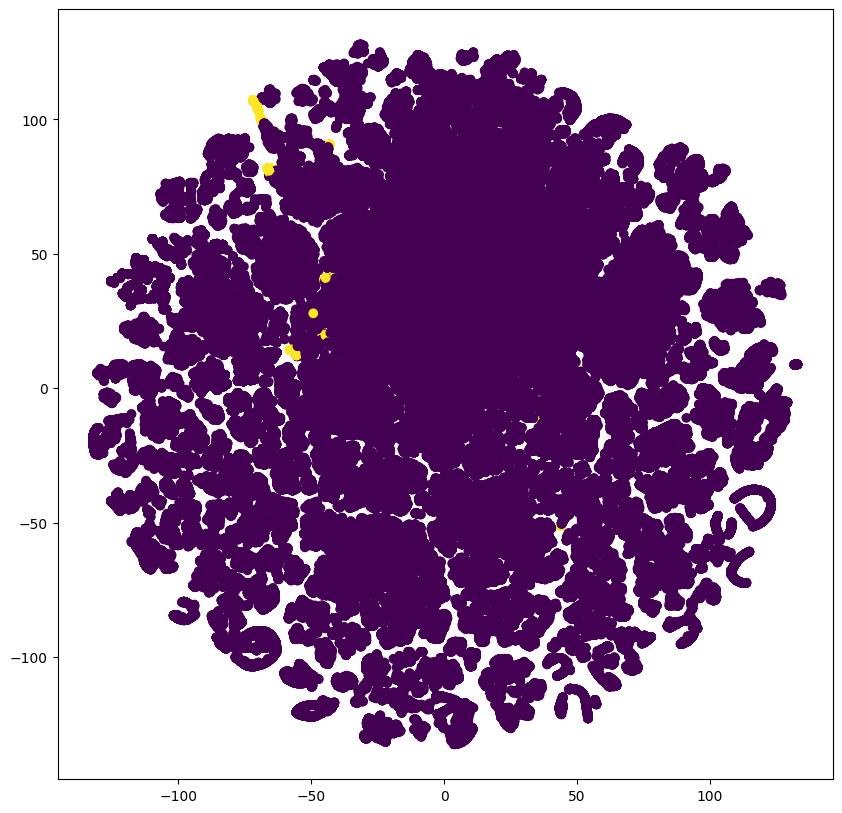

In [47]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=std_outliers);

IQR

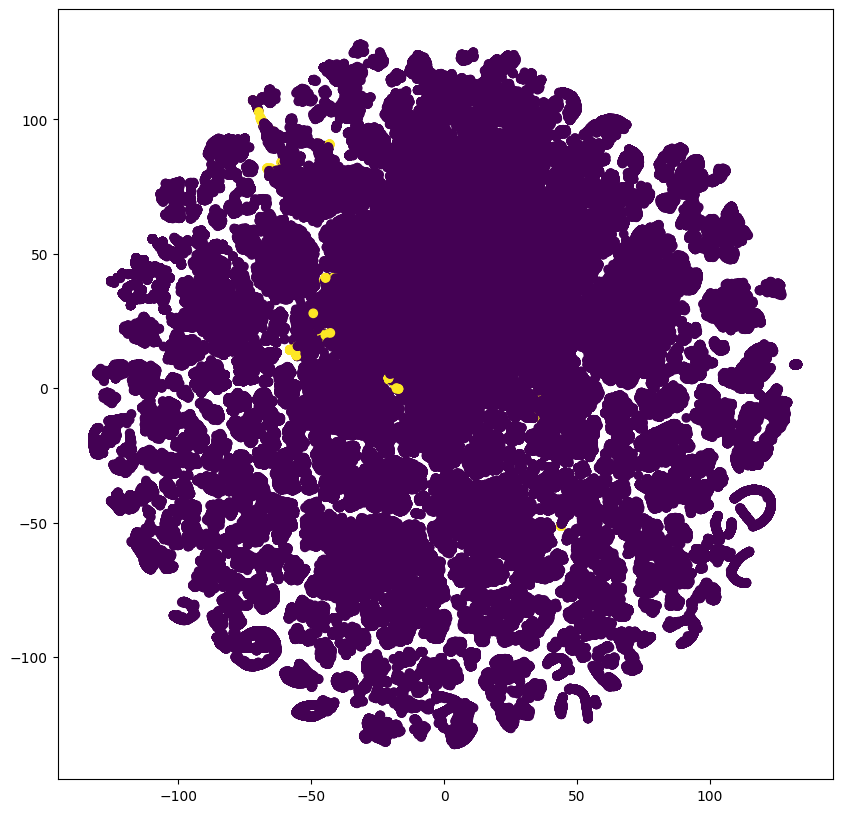

In [48]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=iqr_outliers);

Кластеризация "Euclidian"

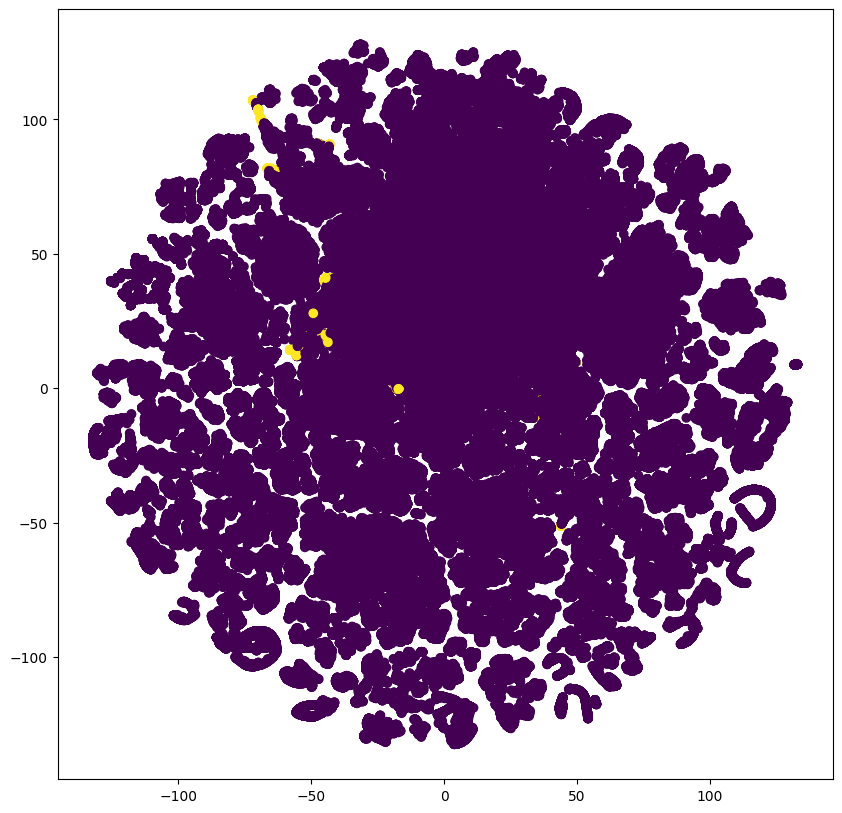

In [49]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

Кластеризация "Cityblock"

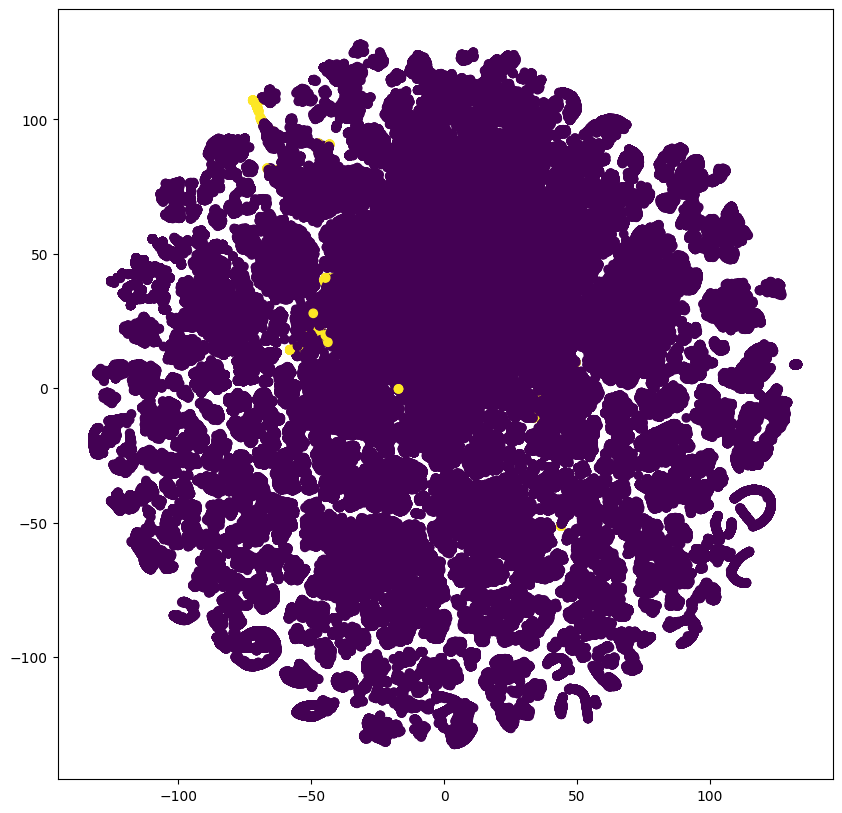

In [50]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cityblock_outliers);

DBSCAN

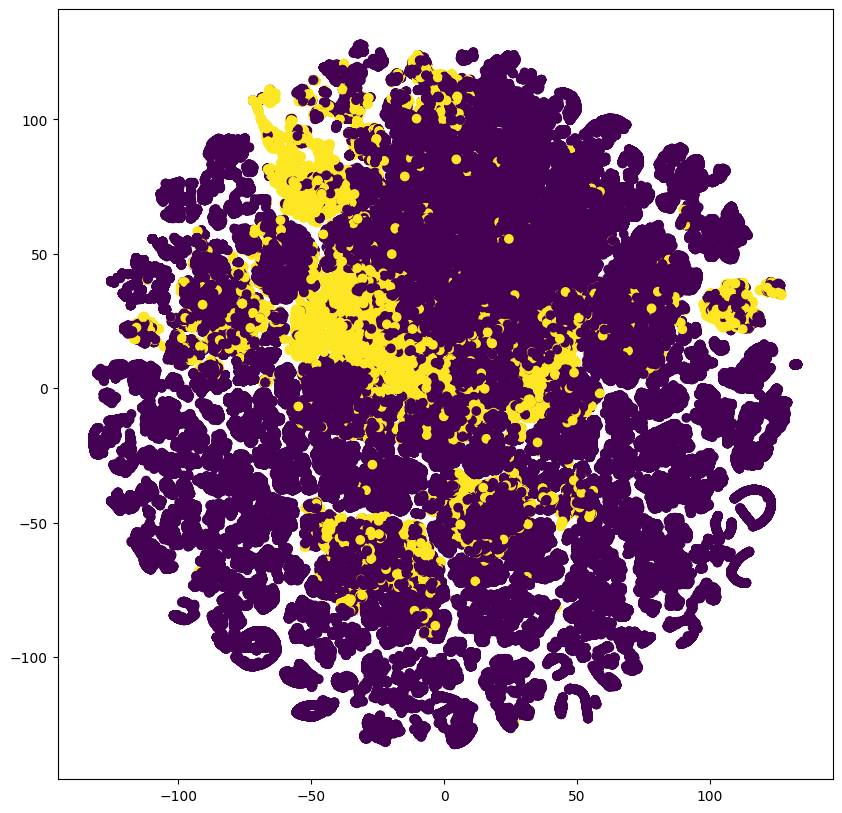

In [51]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=density_outlier);

SVM

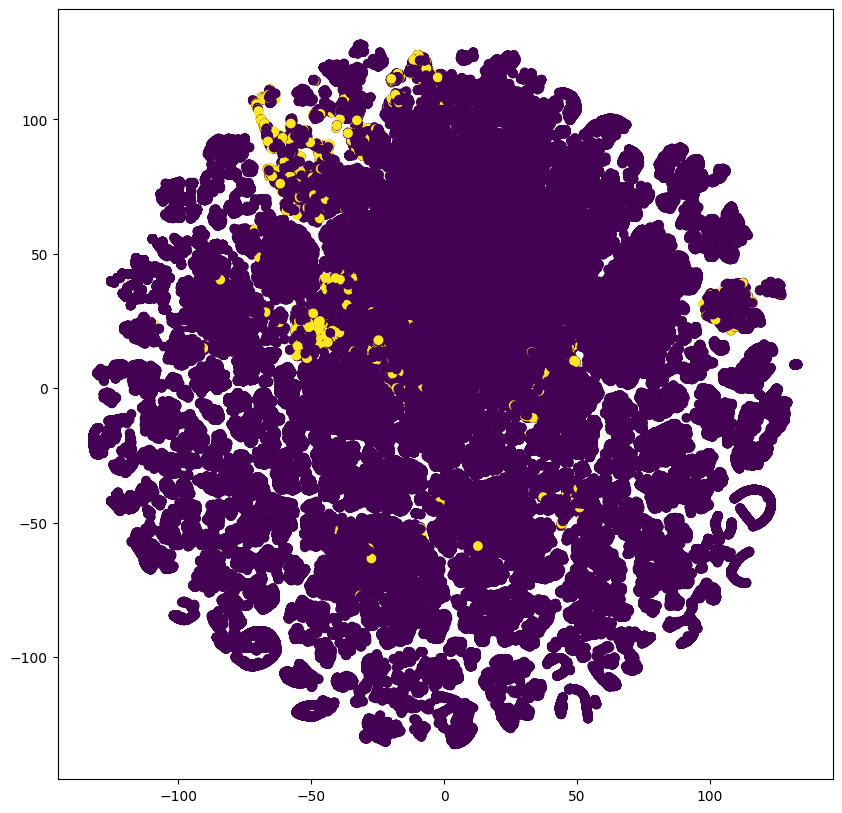

In [52]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=svm_outliers);

Isolation Forest

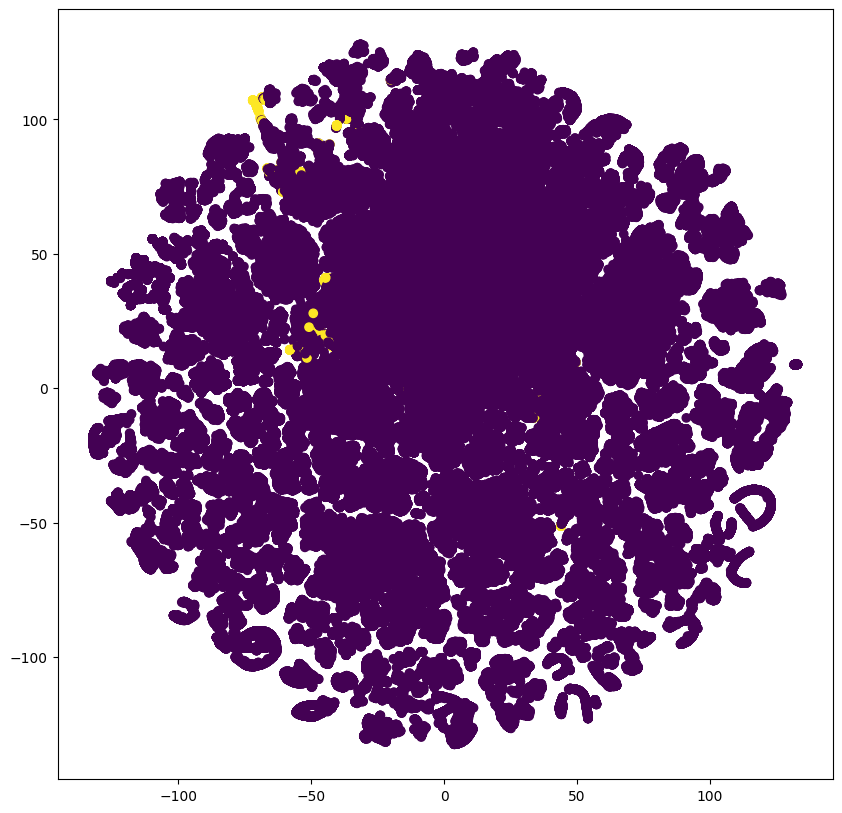

In [53]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=isolation_outliers);

Несмотря на довольно невысокие метрики, на визуализации видно, что характер аномалий на некоторых изображениях схож, с реальными аномалиями